# Attempting to predict Amazons's stock price with a LSTM network
If we could predict stock prices we'd all be billionaires. Unfortunately, it's extremely difficult to accurately predict the future, especially when humans are involved. Luckily for us, machine learning has come a long way in the recent decade with new improvements such as the Long Short-Term Memory (LSTM) network. LSTMs are essentially an improved version of recurrent neural networks (RNNs). For a technical explanation you can check out this link (https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21).
We shall use this network because of its property in selectively remembering patterns for long durations of time. LSTM is relatively good in making predictions based on time series data, since there can be lags of unknown duration between important events in a time series (which happens all the time in the stock market).


## Downloading the data 
I will be using Amazon's historic monthly stock price, which can be downloaded at the link: https://finance.yahoo.com/quote/AMZN/history?period1=1391904000&period2=1581206400&interval=1mo&filter=history&frequency=1mo.
Yahoo finance has various other stocks to choose from.

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Now it's time to import the dataset and view it. We do so using the pandas library and its read_csv function.

In [218]:
data = pd.read_csv('/Users/lukabeverin/Downloads/AMZN-5.csv')
#head is used to view the first 5 observations
data.head()

Date        Open        High         Low       Close   Adj Close  \
0  2014-03-01  358.739990  383.109985  330.880005  336.369995  336.369995   
1  2014-04-01  338.089996  348.299988  288.000000  304.130005  304.130005   
2  2014-05-01  304.130005  314.869995  284.380005  312.549988  312.549988   
3  2014-06-01  312.589996  340.720001  303.839996  324.779999  324.779999   
4  2014-07-01  325.859985  364.850006  311.859985  312.989990  312.989990   

      Volume  
0   75253500  
1  138278700  
2   78579200  
3   76580100  
4   99426000

As a future billionaire, I'm only interested in the Close price. Also, I need to set the Date as the index for the dataframe. Let's do that.

In [219]:
df = data[['Date','Close']]
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df.head()

Close
Date                  
2014-03-01  336.369995
2014-04-01  304.130005
2014-05-01  312.549988
2014-06-01  324.779999
2014-07-01  312.989990

Now in order to see how well our model does, we have to split our data into a training and testing set. The algorithm will use 80% of the data to train itself and then see how well it does against the remaining 20% (which is the test data). 

In [220]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

58 15


So we have 58 data points that will be trained and tested against the remaining 15 points. It's not a lot by any means, but it's enough for the purpose of this demo. 

Next we need to normalise our data. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. Click on this link to understand the difference that normalization makes in neural networks ( https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029 ). I will use MinMaxScaler from the Sci-kit Learn library.

In [221]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In the next few cells we will do the following create an empty list for each of our 12 predictions.
Also create the batch that our model will predict from. Then we save the prediction to our list.
Finally add the prediction to the end of the batch to be used in the next prediction. LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.

The TimeseriesGenerator class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

n_input is the length of the output sequences (in number of timesteps).

The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. 

In [222]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

## The LSTM model
The LSTM model is implemented below. It is a fairly simple model to make use of. Note that we use the Mean squared error as the parameter that we would like to minimise. There are resources on how to fine tune your hyperparameters such as the batch size and epoch, but we won't go into that. If you're interested, read up on it and see if you can improve this model. 

In [223]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Now we fit our model with an epoch value. The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. The number of epochs is traditionally large, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. But not too large, otherwise we risk overfitting. Check out this link that describes batch size and epochs in a very intuitive way (https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

In [240]:
model.fit_generator(generator,epochs=100)

Epoch 1/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0079
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0080
Epoch 3/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0101
Epoch 4/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0085
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0054
Epoch 6/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0058
Epoch 8/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0062
Epoch 9/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0074
Epoch 10/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0070
Epoch 11/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0053
Epoch 12/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0046
Epoch 13/100
11/11 [=====

In [241]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Creating a dataframe out of the prediction list, which is concatenated with the original dataframe. Also, scaler.inverse_transform reverses the scaling/normalisation that we did in the beginning.

In [242]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)

## Plot the predictions vs the actual values
The red line is the predicted values for the past 12 months. Notice that is linear and horizontal. It doesn't have any up and down movements that is visible in the historical data (blue line). Let's give LSTM a break, it's extremely difficult to predict these sudden up and down changes, even when a large amount of data is available. These spikes are usually due to human actions and are very volatile.. 

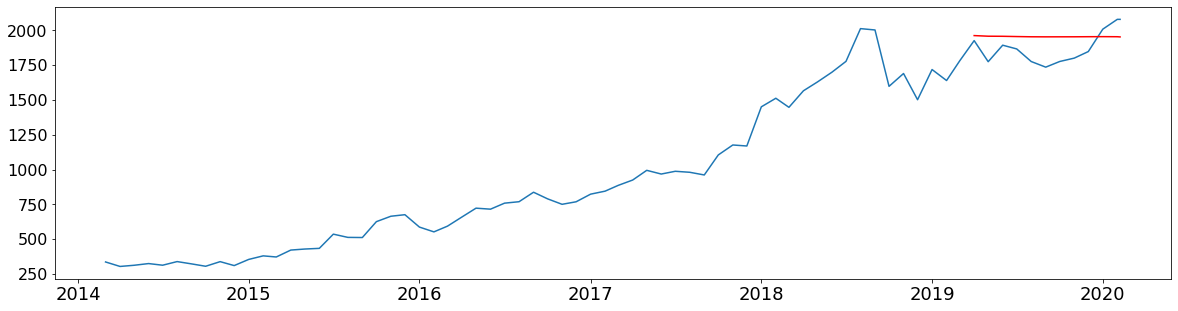

In [252]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Close'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

Let's calculate the root mean squared error (RMSE).

In [244]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [137.39644477]


# Predict the future stock price (or try our best)
We aim to forecast Amazon's monthly closing price for the next 12 months. The code is similar to before, except for the index being set to the future dates. 


In [245]:
train = df

In [246]:
scaler.fit(train)
train = scaler.transform(train)

Again, we want to predict the next 12 months, hence n_input = 12

In [232]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [247]:
model.fit_generator(generator,epochs=100)

Epoch 1/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0035
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0049
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0038
Epoch 5/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 6/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0055
Epoch 7/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0058
Epoch 8/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0057
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0065
Epoch 10/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0054
Epoch 11/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 12/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 13/100
11/11 [=====

In [248]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In the cell below we just create our new dates for the next 12 months.

In [249]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [250]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

## Plot of the forecasted stock price's
The red line is the forecasted stock price.

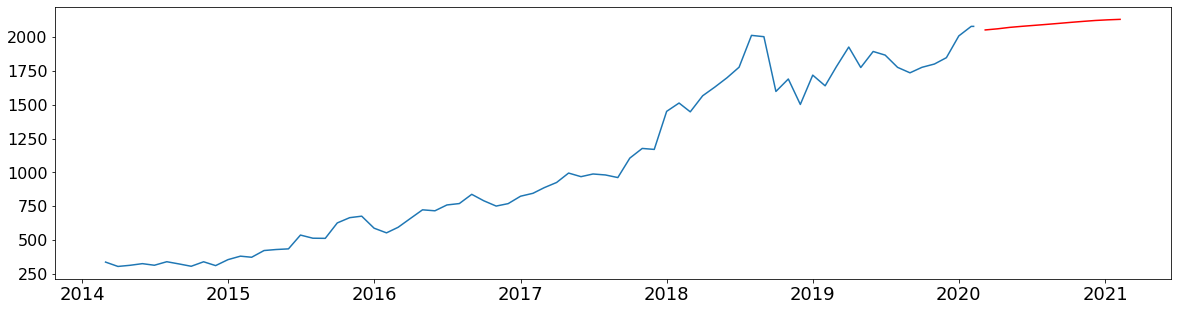

In [251]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Close'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

Finally, we output our predictions. 

In [253]:
df_proj.tail()

Close   Prediction
2020-10-07    NaN  2109.031105
2020-11-07    NaN  2116.308735
2020-12-07    NaN  2122.868992
2021-01-07    NaN  2127.627565
2021-02-07    NaN  2131.197711

Now that you have predicted the future, it's time to go to the bank and cash that cheque.
Wait ..before you do that, you can see that the predictions are fairly linear but going with the overall upwards trend. It's completely possible for the stock price to go down the next month due to some unknown reason ( Breaking news: Jeff Bezos retires to live in Thailand and opens a bubble tea store). But like I said, if we could predict the stock market with certainty, we'd all be rich, but unfortunately it's not that easy. Even with the power of machine learning it has been proven to be a daunting task. 
Side note: Anyone know those forex traders with the chrome cars? They seem to have the secret formula ..

### References 
A lot of credit must be given to Ian Falton

https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d

Notebook completed by Luka Beverin